# 02b. Cleaning and Transforming to Create a Geospatial Dataset

This notebook demonstrates some of the steps involved in cleaning the NEH grant data, checking on quality and consistency, and then transforming the data into geospatial information that can be the basis of a map. While most of the data is contained within the steps and cells of this notebook, at the end there is a script to use to export the final information as `geojson`, which can be used elsewhere or for other purposes. It is more consistent and portable than the original data.

## Setup

For this activity, we will use some Python modules that may not be in the standard JupyterLab configuration. If you do not have them, you may need to install some of these modules: `geojson` ([here](https://pypi.org/project/geojson/#installation)), `geopandas` ([here](https://pypi.org/project/geopandas/)), `geopy` ([here](https://pypi.org/project/geopy/)), `descartes` ([here](https://pypi.org/project/descartes/)), and `shapely` ([here](https://pypi.org/project/shapely/)).

In [ ]:
# if you do not have the modules, uncomment the following line(s) to install
#!pip install geojson
#!pip install geopandas
#!pip install descartes
#!pip install geopy

In [1]:
# modules for data cleaning & transformation
import pandas as pd
import geopandas as gpd

# basic visualization
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# modules for mapping
from shapely.geometry import Point

# may use for additional visualization
import seaborn as sns

# modules for geocoding
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from time import sleep

## Clean and filter the grant data using pandas

First, let's explore the grant data and clean it up so that we can define the points that we will map - there should be one coordinate location for each grant that we want to display. For this task, we will begin using the `pandas` modules for working with data. 

In [3]:
df_grants_1960s = pd.read_csv('neh-grants-data-202012/data/NEH_Grants1960s.csv')

df_grants_1960s.head()

,AppNumber,ApplicantType,Institution,OrganizationType,InstCity,InstState,InstPostalCode,InstCountry,CongressionalDistrict,Latitude,...,EndGrant,ProjectDesc,ToSupport,PrimaryDiscipline,SupplementCount,Supplements,ParticipantCount,Participants,DisciplineCount,Disciplines
0,FB-10007-68,2,"Regents of the University of California, Berkeley",Four-Year College,Berkeley,CA,94704-5940,USA,13,37.87029,...,1969-12-31,No description,No to support statement,English,0,NaN,1,John Elliot [Project Director],1,English
1,FB-10009-68,2,Pitzer College,Four-Year College,Claremont,CA,91711-6101,USA,27,34.10373,...,1969-12-31,No description,No to support statement,History of Religion,0,NaN,1,Steven Matthysse [Project Director],1,History of Religion
2,FB-10015-68,2,"University of California, Riverside",University,Riverside,CA,92521-0001,USA,41,33.97561,...,1969-12-31,No description,No to support statement,"History, General",0,NaN,1,John Staude [Project Director],1,"History, General"
3,FB-10019-68,2,Northeastern University,Four-Year College,Boston,MA,02115-5005,USA,7,42.3395,...,1969-12-31,No description,No to support statement,"History, General",0,NaN,1,Thomas Havens [Project Director],1,"History, General"
4,FB-10023-68,2,University of Pennsylvania,University,Philadelphia,PA,19104-6205,USA,3,39.95298,...,1969-12-31,No description,No to support statement,Psychology,0,NaN,1,Gresham Riley [Project Director],1,Psychology


It's important to explore the dataset a bit first, so we can understand it better, do a sanity check, and identify the information that is needed to create a new set of mappable point data. The pandas library allows to easily do some of this basic work, including characterizing the shape of the data, seeing what datatypes it includes, and whether it is missing values.

In [4]:
df_grants_1960s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AppNumber              1010 non-null   object 
 1   ApplicantType          1010 non-null   int64  
 2   Institution            1010 non-null   object 
 3   OrganizationType       1010 non-null   object 
 4   InstCity               1010 non-null   object 
 5   InstState              1010 non-null   object 
 6   InstPostalCode         1010 non-null   object 
 7   InstCountry            1010 non-null   object 
 8   CongressionalDistrict  1010 non-null   int64  
 9   Latitude               1010 non-null   object 
 10  Longitude              1010 non-null   object 
 11  CouncilDate            1010 non-null   object 
 12  YearAwarded            1010 non-null   int64  
 13  ProjectTitle           1010 non-null   object 
 14  Program                1010 non-null   object 
 15  Divi

Latitude and Longitude series are listed as data objects, not numeric data. I will convert these into numeric data later since it is necessary to process them into geospatial coordinates as numbers, not strings. On closer inspection, many of these fields include the strings "Unknown", "unknown", or "Un", which I also want to change to null or None values. First, though, I will create a new data frame so this original data can be recovered later, if necessary, and also drop some of the information that I won't need to map the grants. 

### Data quality checking and cleaning

There's a lot of information here that won't help to map the data. Aside from the information for location of the points (that is, `Latitude` and `Longitude`), I will keep some for use in a popup that can be displayed when hovering over a point on the map. 

I regularly use panda's `isnull()` and `info()` functions below to look for blank cells or missing information. 

In [5]:
mappable_grant_info = df_grants_1960s.drop(['ApplicantType','OrganizationType','CouncilDate','ApprovedOutright','ApprovedMatching','OriginalAmount','SupplementAmount','BeginGrant','EndGrant','PrimaryDiscipline','SupplementCount','Supplements','ParticipantCount','DisciplineCount'], axis=1)

mappable_grant_info.head()

,AppNumber,Institution,InstCity,InstState,InstPostalCode,InstCountry,CongressionalDistrict,Latitude,Longitude,YearAwarded,ProjectTitle,Program,Division,AwardOutright,AwardMatching,ProjectDesc,ToSupport,Participants,Disciplines
0,FB-10007-68,"Regents of the University of California, Berkeley",Berkeley,CA,94704-5940,USA,13,37.87029,-122.26813,1967,Title not available,Fellowships for Younger Scholars,Fellowships and Seminars,8387.0,0.0,No description,No to support statement,John Elliot [Project Director],English
1,FB-10009-68,Pitzer College,Claremont,CA,91711-6101,USA,27,34.10373,-117.70701,1967,Title not available,Fellowships for Younger Scholars,Fellowships and Seminars,8387.0,0.0,No description,No to support statement,Steven Matthysse [Project Director],History of Religion
2,FB-10015-68,"University of California, Riverside",Riverside,CA,92521-0001,USA,41,33.97561,-117.33113,1967,Title not available,Fellowships for Younger Scholars,Fellowships and Seminars,8387.0,0.0,No description,No to support statement,John Staude [Project Director],"History, General"
3,FB-10019-68,Northeastern University,Boston,MA,02115-5005,USA,7,42.3395,-71.09048,1967,Title not available,Fellowships for Younger Scholars,Fellowships and Seminars,8387.0,0.0,No description,No to support statement,Thomas Havens [Project Director],"History, General"
4,FB-10023-68,University of Pennsylvania,Philadelphia,PA,19104-6205,USA,3,39.95298,-75.19276,1967,Title not available,Fellowships for Younger Scholars,Fellowships and Seminars,8387.0,0.0,No description,No to support statement,Gresham Riley [Project Director],Psychology


In [6]:
mappable_grant_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AppNumber              1010 non-null   object 
 1   Institution            1010 non-null   object 
 2   InstCity               1010 non-null   object 
 3   InstState              1010 non-null   object 
 4   InstPostalCode         1010 non-null   object 
 5   InstCountry            1010 non-null   object 
 6   CongressionalDistrict  1010 non-null   int64  
 7   Latitude               1010 non-null   object 
 8   Longitude              1010 non-null   object 
 9   YearAwarded            1010 non-null   int64  
 10  ProjectTitle           1010 non-null   object 
 11  Program                1010 non-null   object 
 12  Division               1010 non-null   object 
 13  AwardOutright          1010 non-null   float64
 14  AwardMatching          1010 non-null   float64
 15  Proj

While there are entries for each grant, on closer inspection it is clear that there are some data quality issues. For example, a lot of grants seem to be missing `Participants` information, and the latitude and longitude information, which will be the basis for our mapping goal, is not numerical but listed as an object type of data. As I can see in the above cell, much of the information is described as "object," which in these case are mostly string data, which will not be possible to convert into coordinate points. 

This means that there is more data cleaning to do before the data is ready to map. I used the following methods to get more information about specific data fields, including `AppNumber` (the data element that is most like a unique identifier), `Latitude` (a creator-generated field, which is presumably generated by a geocoding algorithm), 
and `InstCountry`.

In [7]:
mappable_grant_info['AppNumber'].value_counts()

RO-10389       1
EO-10051-68    1
RO-10259-68    1
FB-10225-68    1
FT-10147-67    1
              ..
EO-10302-69    1
EO-10085-69    1
EO-10242-69    1
FT-10294-68    1
FT-10157-67    1
Name: AppNumber, Length: 1010, dtype: int64

In [8]:
mappable_grant_info['Latitude'].value_counts()

Unknown     90
41.31003    17
40.81835    16
34.07516    16
37.87029    14
            ..
40.771       1
42.82649     1
40.85069     1
42.29017     1
42.35675     1
Name: Latitude, Length: 382, dtype: int64

In looking closer at `InstCounty`, it is clear that not all of the grants were given to recipients within the United States. As a scoping exericse, I want to remove the locations that are not within the US.

In [9]:
mappable_grant_info['InstCountry'].unique()

array(['USA', 'Unknown', 'Canada', 'United Kingdom'], dtype=object)

In [10]:
mappable_grant_info['InstCountry'].value_counts()

USA               993
Unknown            14
Canada              2
United Kingdom      1
Name: InstCountry, dtype: int64

Many of the grant entries list `Unknown` or `unknown` in the fields with information about country, institution, and even latitude or longitude. This challenges our mapping project since if we cannot locate a grant, we cannot create a point to place it on the map. To address these challenges, we need first to identify grants withough location information, then we need to get the locations of the places without latitude and longitude. For the latter step, we will use a geocoding module.

For scoping, let's drop the UK and Canada grants, and then see whether we can geolocate the unknowns.

In [11]:
#filter out Canada & UK
mappable_grant_info = mappable_grant_info[mappable_grant_info['InstCountry'].isin(['Canada','United Kingdom']) == False]

In [12]:
mappable_grant_info['InstCountry'].value_counts()

USA        993
Unknown     14
Name: InstCountry, dtype: int64

My goal is to use information about the city and state of the award to get a geographic coordinate for the 14 listing "Unknown" countries. There remain, however, a few entries that don't appear to have enough information to geocode. 

These can be identified by the value `Un` in the `InstState` field:

In [13]:
mappable_grant_info[mappable_grant_info['InstState'] == 'Un']

,AppNumber,Institution,InstCity,InstState,InstPostalCode,InstCountry,CongressionalDistrict,Latitude,Longitude,YearAwarded,ProjectTitle,Program,Division,AwardOutright,AwardMatching,ProjectDesc,ToSupport,Participants,Disciplines
221,FB-10243-68,Unknown,Unknown,Un,Unknown,Unknown,0,Unknown,unknown,1967,Title not available,Fellowships for College Teachers and Independe...,Research Programs,8387.0,0.0,No description,No to support statement,NaN,Comparative Literature
337,FT-10440-68,Unknown,Unknown,Un,Unknown,Unknown,0,Unknown,unknown,1967,Title not available,Summer Stipends,Research Programs,1500.0,0.0,No description,No to support statement,NaN,English
428,RO-10048-67,Unknown,Unknown,Un,Unknown,Unknown,0,Unknown,unknown,1967,Biography of Theodore Roethke,Basic Research,Research Programs,5000.0,0.0,No description,No to support statement,NaN,Art History and Criticism
429,RO-10050-67,Unknown,Unknown,Un,Unknown,Unknown,0,Unknown,unknown,1967,Symbolic Landscape in Modern Poetry,Basic Research,Research Programs,2000.0,0.0,No description,No to support statement,NaN,American Literature
454,RO-10166-67,Unknown,Unknown,Un,Unknown,Unknown,0,Unknown,unknown,1967,History of Book Publishing in America,Basic Research,Research Programs,25000.0,0.0,No description,No to support statement,NaN,"History, General"
459,RO-10211-68,Unknown,Unknown,Un,Unknown,Unknown,0,Unknown,unknown,1968,Biography of Richard Wright,Basic Research,Research Programs,8000.0,0.0,No description,No to support statement,NaN,"Literature, General"
480,RO-10317-69,Unknown,Unknown,Un,Unknown,Unknown,0,Unknown,unknown,1968,Biography of Richard Wright,Basic Research,Research Programs,8000.0,0.0,No description,No to support statement,NaN,"Literature, General; Social Sciences, General"
757,FT-10257-67,McMaster University,"Ontario, Canada",Un,00000-0000,USA,1,Unknown,unknown,1967,Title not available,Summer Stipends,Research Programs,2000.0,0.0,No description,No to support statement,Chauncey Wood [Project Director],British Literature
774,FT-10310-68,Simon Fraser University,"B.C., Canada",Un,00000-0000,USA,0,Unknown,unknown,1967,Title not available,Summer Stipends,Research Programs,1500.0,0.0,No description,No to support statement,Jared Curtis [Project Director],"English; Literature, General"


It is clear that most of these do not have enough information to map. The last two are in Canada, and so I don't want them anyway. So I'll remove them from the data:

In [14]:
#filter out unknown state rows
mappable_grant_info = mappable_grant_info[mappable_grant_info['InstState'].isin(['Un']) == False]

In [15]:
mappable_grant_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 1009
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AppNumber              998 non-null    object 
 1   Institution            998 non-null    object 
 2   InstCity               998 non-null    object 
 3   InstState              998 non-null    object 
 4   InstPostalCode         998 non-null    object 
 5   InstCountry            998 non-null    object 
 6   CongressionalDistrict  998 non-null    int64  
 7   Latitude               998 non-null    object 
 8   Longitude              998 non-null    object 
 9   YearAwarded            998 non-null    int64  
 10  ProjectTitle           998 non-null    object 
 11  Program                998 non-null    object 
 12  Division               998 non-null    object 
 13  AwardOutright          998 non-null    float64
 14  AwardMatching          998 non-null    float64
 15  Proje

Let's take a closer look at the latitude and longitude information, which will be the basis for determining each point to map later on. This reveals that there are still at least 78 entries without location information:

In [16]:
mappable_grant_info['Latitude'].describe()

count         998
unique        382
top       Unknown
freq           78
Name: Latitude, dtype: object

In [17]:
mappable_grant_info['Longitude'].describe()

count         998
unique        383
top       unknown
freq           78
Name: Longitude, dtype: object

It will not be possible to map these grants without further information. My goal is to use data from the city and state location fields, which I can send to a geocoding tool in order to provide a location coordinate. To begin, I will remove the string values "unknown" or "Unknown" in the dataset and then replace them with null (blank) values, which I can filter more easily. Then, I will use Nominatim, a geocoding tool that will search for coordinate information based on the available place information.

In [18]:
# replace strings with null values
nonvals = ['unknown','Unknown']

mappable_grant_info = mappable_grant_info.replace(nonvals, [None, None])

latlons = mappable_grant_info.loc[:,'Latitude':'Longitude']

print(latlons['Latitude'],'\n')
print('Is it a null value?',type(mappable_grant_info.loc[1009,'Latitude']))

0       37.87029
1       34.10373
2       33.97561
3        42.3395
4       39.95298
          ...   
1005    40.74955
1006    32.88647
1007    41.02476
1008    29.94888
1009        None
Name: Latitude, Length: 998, dtype: object 

Is it a null value? <class 'NoneType'>


In [19]:
mappable_grant_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 1009
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AppNumber              998 non-null    object 
 1   Institution            970 non-null    object 
 2   InstCity               997 non-null    object 
 3   InstState              998 non-null    object 
 4   InstPostalCode         970 non-null    object 
 5   InstCountry            991 non-null    object 
 6   CongressionalDistrict  998 non-null    int64  
 7   Latitude               920 non-null    object 
 8   Longitude              920 non-null    object 
 9   YearAwarded            998 non-null    int64  
 10  ProjectTitle           998 non-null    object 
 11  Program                998 non-null    object 
 12  Division               998 non-null    object 
 13  AwardOutright          998 non-null    float64
 14  AwardMatching          998 non-null    float64
 15  Proje

Since there are only 920 Lat & Lon entries, that leaves the 78 unknown (now null) entries wihtout information. While it would be possible to gather this information with a tool like [Get Lat+Lon](http://teczno.com/squares/#6/41.60/-93.66), that would take while. So I will use the information about the recipient's city and state to get a general idea of where the award was given.

In [20]:
# create a geoquery string, which will allow to at least map the city
mappable_grant_info['geoquery'] = mappable_grant_info['InstCity'] + ' ' + mappable_grant_info['InstState']

mappable_grant_info[mappable_grant_info['geoquery'].isnull()]

,AppNumber,Institution,InstCity,InstState,InstPostalCode,InstCountry,CongressionalDistrict,Latitude,Longitude,YearAwarded,ProjectTitle,Program,Division,AwardOutright,AwardMatching,ProjectDesc,ToSupport,Participants,Disciplines,geoquery
168,FA-10157-68,None,None,NY,None,USA,0,None,None,1967,Title not available,Fellowships for University Teachers,Research Programs,15520.0,0.0,No description,No to support statement,NaN,U.S. History,NaN


Now there's only one left that lacks enough information. To check, look at that grant:

In [21]:
mappable_grant_info.loc[168, :]

AppNumber                                        FA-10157-68
Institution                                             None
InstCity                                                None
InstState                                                 NY
InstPostalCode                                          None
InstCountry                                              USA
CongressionalDistrict                                      0
Latitude                                                None
Longitude                                               None
YearAwarded                                             1967
ProjectTitle                             Title not available
Program                  Fellowships for University Teachers
Division                                   Research Programs
AwardOutright                                          15520
AwardMatching                                              0
ProjectDesc                                   No description
ToSupport               

There is just not enough information here - the record does not include information about the city or institution that received this award, so remove that one, too.

In [22]:
mappable_grant_info = mappable_grant_info.drop([168])

mappable_grant_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 1009
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AppNumber              997 non-null    object 
 1   Institution            970 non-null    object 
 2   InstCity               997 non-null    object 
 3   InstState              997 non-null    object 
 4   InstPostalCode         970 non-null    object 
 5   InstCountry            990 non-null    object 
 6   CongressionalDistrict  997 non-null    int64  
 7   Latitude               920 non-null    object 
 8   Longitude              920 non-null    object 
 9   YearAwarded            997 non-null    int64  
 10  ProjectTitle           997 non-null    object 
 11  Program                997 non-null    object 
 12  Division               997 non-null    object 
 13  AwardOutright          997 non-null    float64
 14  AwardMatching          997 non-null    float64
 15  Proje

### Geocode grants missing location coordinates

For the remaining 77 grants without location information, try to geocode by city and state information.

In [23]:
# create a subset of the information for geoquerying
geoQuerySet = mappable_grant_info.loc[:, ['AppNumber','InstCity','InstState','Latitude','Longitude','geoquery']]

#pull out the entries without location coordinates
geoQuerySet = geoQuerySet[geoQuerySet['Latitude'].isnull()]

geoQuerySet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 24 to 1009
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   AppNumber  77 non-null     object
 1   InstCity   77 non-null     object
 2   InstState  77 non-null     object
 3   Latitude   0 non-null      object
 4   Longitude  0 non-null      object
 5   geoquery   77 non-null     object
dtypes: object(6)
memory usage: 4.2+ KB


In [24]:
# set up geolocator
# increase timeout to reduce errors 
geolocator = Nominatim(user_agent='neh-grant-points', timeout=10)

# limit to comply with rate limiting requirements
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# initiate geolocation for the 77 grants
geoQuerySet['location'] = geoQuerySet['geoquery'].apply(geocode)

In [25]:
geoQuerySet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 24 to 1009
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   AppNumber  77 non-null     object
 1   InstCity   77 non-null     object
 2   InstState  77 non-null     object
 3   Latitude   0 non-null      object
 4   Longitude  0 non-null      object
 5   geoquery   77 non-null     object
 6   location   76 non-null     object
dtypes: object(7)
memory usage: 4.8+ KB


All but one of the `geoquery` requests returned a location value. To see what's missing, check for the empty values using `isnull()`:

In [26]:
geoQuerySet[geoQuerySet['location'].isnull()]

,AppNumber,InstCity,InstState,Latitude,Longitude,geoquery,location
998,RP-10003-68,Charlottsvlle,VA,None,None,Charlottsvlle VA,None


Looks like that one has a typo! _I adapted the fix & replace process that @cduvallet outlined (link to full process at the end of this post)._

In [27]:
fixgeolocate = {
    'Charlottsvlle VA' : 'Charlottesville VA'
}

new_locations = {}
for key, val in fixgeolocate.items():
    loc = geocode(val)
    new_locations[key] = loc
    sleep(1)
print(new_locations)

{'Charlottsvlle VA': Location(The V, 201-213, 15th Street Northwest, Venable, Starr Hill, Charlottesville, Virginia, 22903, United States, (38.0360726, -78.49973472559668, 0.0))}


While here, I will also correct the typo in the dataset.

In [28]:
# update to correct spelling of Charlottesville in cleaned_grants_for_mappable = mappable_grant_info i=998
mappable_grant_info = mappable_grant_info.replace('Charlottsvlle','Charlottesville')

In [29]:
# update the geoquery set 
# get indices of rows with no location
null_locs = geoQuerySet[geoQuerySet['location'].isnull()].index

# sub in the new_locs
geoQuerySet.loc[null_locs, 'location'] = geoQuerySet.loc[null_locs, 'geoquery'].map(new_locations)

In [30]:
geoQuerySet.head()

,AppNumber,InstCity,InstState,Latitude,Longitude,geoquery,location
24,AO-10025-69,Westport,CT,None,None,Westport CT,"(Westport Court, Westport, Columbia County, Ge..."
40,EH-10038-68,Evanston,IL,None,None,Evanston IL,"(Evanston, Evanston Township, Cook County, Ill..."
47,EH-10058-66,New York,NY,None,None,New York NY,"(New York, United States, (40.7127281, -74.006..."
51,EO-10001-67,Dover,DE,None,None,Dover DE,"(Dover, Kent County, Delaware, United States, ..."
61,EO-10051-68,University Park,PA,None,None,University Park PA,"(University Park, College Township, Centre Cou..."


Now we have all information to provide a coordinate location for those grants that didn't have the information. What remains is to pull the Lat & Lon information back into those columns.

In [31]:
# pull the lats & lons from the locations - see 
geoQuerySet['Latitude'] = geoQuerySet['location'].apply(lambda x: x.latitude)
geoQuerySet['Longitude'] = geoQuerySet['location'].apply(lambda x: x.longitude)

geoQuerySet.head()

,AppNumber,InstCity,InstState,Latitude,Longitude,geoquery,location
24,AO-10025-69,Westport,CT,33.554852,-82.066172,Westport CT,"(Westport Court, Westport, Columbia County, Ge..."
40,EH-10038-68,Evanston,IL,42.044739,-87.693046,Evanston IL,"(Evanston, Evanston Township, Cook County, Ill..."
47,EH-10058-66,New York,NY,40.712728,-74.006015,New York NY,"(New York, United States, (40.7127281, -74.006..."
51,EO-10001-67,Dover,DE,39.158168,-75.524368,Dover DE,"(Dover, Kent County, Delaware, United States, ..."
61,EO-10051-68,University Park,PA,40.808749,-77.858566,University Park PA,"(University Park, College Township, Centre Cou..."


In [32]:
geoQuerySet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 24 to 1009
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AppNumber  77 non-null     object 
 1   InstCity   77 non-null     object 
 2   InstState  77 non-null     object 
 3   Latitude   77 non-null     float64
 4   Longitude  77 non-null     float64
 5   geoquery   77 non-null     object 
 6   location   77 non-null     object 
dtypes: float64(2), object(5)
memory usage: 7.3+ KB


### Merge the data

I can see using `info()` that the main dataframe still lacks the latitude and longitude information for the newly points geocoded points. So now, let's merge the locations back into the dataframe for mapping (`cleaned_grants_for_mappable`).

In [33]:
# create a clean dataframe, just in case something happens to remove data
cleaned_grants_for_mappable = mappable_grant_info

In [34]:
cleaned_grants_for_mappable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 1009
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AppNumber              997 non-null    object 
 1   Institution            970 non-null    object 
 2   InstCity               997 non-null    object 
 3   InstState              997 non-null    object 
 4   InstPostalCode         970 non-null    object 
 5   InstCountry            990 non-null    object 
 6   CongressionalDistrict  997 non-null    int64  
 7   Latitude               920 non-null    object 
 8   Longitude              920 non-null    object 
 9   YearAwarded            997 non-null    int64  
 10  ProjectTitle           997 non-null    object 
 11  Program                997 non-null    object 
 12  Division               997 non-null    object 
 13  AwardOutright          997 non-null    float64
 14  AwardMatching          997 non-null    float64
 15  Proje

In [35]:
# create a list of the indices for matching rows between the data frames
geoInfotoReplaceIndices = geoQuerySet.loc[:,'AppNumber'].index
geoInfotoReplaceIndices

Int64Index([  24,   40,   47,   51,   61,   74,   83,  103,  106,  107,  110,
             111,  117,  120,  123,  124,  148,  151,  154,  174,  188,  198,
             209,  341,  359,  378,  386,  387,  388,  398,  402,  412,  430,
             437,  477,  482,  483,  484,  511,  522,  553,  597,  608,  624,
             637,  669,  685,  689,  702,  708,  746,  750,  779,  791,  795,
             802,  855,  856,  857,  859,  860,  861,  866,  871,  872,  885,
             890,  902,  927,  936,  938,  940,  961,  970,  989,  998, 1009],
           dtype='int64')

In [36]:
# use the row indexes to assign data from the geoQuerySet back to the cleaned map info for Latitude
cleaned_grants_for_mappable.loc[geoInfotoReplaceIndices,['Latitude']] = geoQuerySet.loc[geoInfotoReplaceIndices,['Latitude']]

# use the row indexes to assign data from the geoQuerySet back to the cleaned map info for Longitude
cleaned_grants_for_mappable.loc[geoInfotoReplaceIndices,['Longitude']] = geoQuerySet.loc[geoInfotoReplaceIndices,['Longitude']]

In [37]:
cleaned_grants_for_mappable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 1009
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AppNumber              997 non-null    object 
 1   Institution            970 non-null    object 
 2   InstCity               997 non-null    object 
 3   InstState              997 non-null    object 
 4   InstPostalCode         970 non-null    object 
 5   InstCountry            990 non-null    object 
 6   CongressionalDistrict  997 non-null    int64  
 7   Latitude               997 non-null    object 
 8   Longitude              997 non-null    object 
 9   YearAwarded            997 non-null    int64  
 10  ProjectTitle           997 non-null    object 
 11  Program                997 non-null    object 
 12  Division               997 non-null    object 
 13  AwardOutright          997 non-null    float64
 14  AwardMatching          997 non-null    float64
 15  Proje

In [38]:
# reassign our complete information to the mappable_grant_info dataframe
mappable_grant_info = cleaned_grants_for_mappable

At this point, there are two 'complete' datasets: `cleaned_grants_for_mappable` & `mappable_grant_info`. Below, `mappable_grant_info` is used the main set. 

### Add coordinates and map

Using the filled in latitude and longitude, we can now add in coordinate information to prepare to map each grant as a point on a map.

In [39]:
# convert lat & lon into numeric values
mappable_grant_info.astype({'Latitude':'float64','Longitude':'float64'}).dtypes

AppNumber                 object
Institution               object
InstCity                  object
InstState                 object
InstPostalCode            object
InstCountry               object
CongressionalDistrict      int64
Latitude                 float64
Longitude                float64
YearAwarded                int64
ProjectTitle              object
Program                   object
Division                  object
AwardOutright            float64
AwardMatching            float64
ProjectDesc               object
ToSupport                 object
Participants              object
Disciplines               object
geoquery                  object
dtype: object

In [40]:
# combine latitute and longitude to create coordinate information for mapping
mappable_grant_info['coordinates'] = mappable_grant_info[['Longitude','Latitude']].values.tolist()

mappable_grant_info.tail()

,AppNumber,Institution,InstCity,InstState,InstPostalCode,InstCountry,CongressionalDistrict,Latitude,Longitude,YearAwarded,...,Program,Division,AwardOutright,AwardMatching,ProjectDesc,ToSupport,Participants,Disciplines,geoquery,coordinates
1005,RX-10010-69,American Council of Learned Societies,New York,NY,10017-6706,USA,12,40.74955,-73.97462,1969,...,Conferences,Research Programs,25000.0,0.0,No description,No to support statement,Gordon Turner [Project Director],"Interdisciplinary Studies, General",New York NY,"[-73.97462, 40.74955]"
1006,EO-10125,Salk Institute for Biological Studies,La Jolla,CA,92037-1002,USA,49,32.88647,-117.24392,1969,...,Institutional Planning and Development,Education Programs,7434.0,0.0,To teach a course based on American texts and ...,No to support statement,Christine Tracy [Project Director],"History and Philosophy of Science, Technology,...",La Jolla CA,"[-117.24392, 32.88647]"
1007,EO-10225,Manhattanville College,Purchase,NY,10577-2132,USA,17,41.02476,-73.71567,1969,...,Institutional Planning and Development,Education Programs,28320.0,0.0,No description,No to support statement,Marcus Lawson [Project Director],"Interdisciplinary Studies, General",Purchase NY,"[-73.71567, 41.02476]"
1008,EO-10231,Louisiana Endowment for the Humanities,New Orleans,LA,70113-1027,USA,2,29.94888,-90.07392,1969,...,Institutional Planning and Development,Education Programs,10000.0,0.0,"This is one of seven ""summer workshops on Negr...",No to support statement,Elton Harrison [Project Director],"Interdisciplinary Studies, General",New Orleans LA,"[-90.07392, 29.94888]"
1009,RO-10389,"California State University, Long Beach",Long Beach,CA,90840-0004,USA,48,33.769,-118.192,1969,...,Basic Research,Research Programs,9990.0,0.0,No description,No to support statement,Nizan Shaked [Project Director],"Social Sciences, General",Long Beach CA,"[-118.191604, 33.7690164]"


In [41]:
# create shapely geoPoints for a geometry column
mappable_grant_info['geometry'] = gpd.points_from_xy(mappable_grant_info['Longitude'],mappable_grant_info['Latitude'])

In [42]:
mappable_grant_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 1009
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   AppNumber              997 non-null    object  
 1   Institution            970 non-null    object  
 2   InstCity               997 non-null    object  
 3   InstState              997 non-null    object  
 4   InstPostalCode         970 non-null    object  
 5   InstCountry            990 non-null    object  
 6   CongressionalDistrict  997 non-null    int64   
 7   Latitude               997 non-null    object  
 8   Longitude              997 non-null    object  
 9   YearAwarded            997 non-null    int64   
 10  ProjectTitle           997 non-null    object  
 11  Program                997 non-null    object  
 12  Division               997 non-null    object  
 13  AwardOutright          997 non-null    float64 
 14  AwardMatching          997 non-null    fl

In [44]:
mappable_grant_info['geometry'].describe

<bound method NDFrame.describe of 0       POINT (-122.26813 37.87029)
1       POINT (-117.70701 34.10373)
2       POINT (-117.33113 33.97561)
3        POINT (-71.09048 42.33950)
4        POINT (-75.19276 39.95298)
                   ...             
1005     POINT (-73.97462 40.74955)
1006    POINT (-117.24392 32.88647)
1007     POINT (-73.71567 41.02476)
1008     POINT (-90.07392 29.94888)
1009    POINT (-118.19160 33.76902)
Name: geometry, Length: 997, dtype: geometry>

The geometry column now contains POINTs, a special datatype that will be necessary for the geospatial dataset.

For the final steps of cleaning and transforming this data to a geospatial dataset, the `geopandas` module provides more options, so I will convert the data to geopandas (aka "gpd") now:

In [45]:
# convert the information to a geopandas dataframe
mappable_gdf = gpd.GeoDataFrame(mappable_grant_info)

Using the `type()` function, I can see that this is now a "GeoDataFrame" with "GeoSeries" in some of the fields.

In [46]:
type(mappable_gdf)

geopandas.geodataframe.GeoDataFrame

In [47]:
type(mappable_gdf['geometry'])

geopandas.geoseries.GeoSeries

At this point, the `mappable_gdf` data is ready to plot on a map. For these purposes, the data is cleaned and consistent and contains the necessary geospatial coordinates to create a point for each of the 997 grants made during the 1960s decade for which NEH maintained information about the location of the award, and that were made to the U.S. states. 

## Data cleanup by geography

Now I have relatively clean data, and I can use basic mapping functions of geopandas to get an idea of any egregious outliers. For this task, geopandas supports some basic mapping tools (some of the built-in mapping features [included in geopandas](https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html)) to get an idea of additional data errors. Once I have taken these additional steps, I can export this data for use later on to create more detailed maps. 

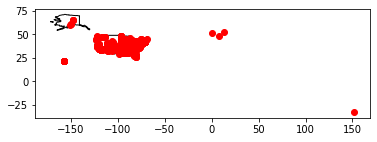

In [48]:
# create a mapspace for the geodataframe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

usa = world.query('name == "United States of America"')

ax = usa.plot(
    color='white', edgecolor='black'
)

mappable_gdf.plot(ax=ax, color='red')

plt.show()

The map is small, but this offers an initial data quality check, and I can see that there are a few points that don't look right. There may be some in Europe (or Canada?) and one that appears to be in the Pacific. It's possible that this is a grant to American Samoa or another US territory in the Pacific, but I want to find out. 

In [49]:
# find the distant outlier... 

mappable_gdf.sort_values(by=['Latitude','Longitude']).head(2)

,AppNumber,Institution,InstCity,InstState,InstPostalCode,InstCountry,CongressionalDistrict,Latitude,Longitude,YearAwarded,...,Division,AwardOutright,AwardMatching,ProjectDesc,ToSupport,Participants,Disciplines,geoquery,coordinates,geometry
151,FA-10103-67,None,Richmond,VA,None,None,0,-32.8652,151.501,1967,...,Research Programs,13270.0,0.0,No description,No to support statement,NaN,U.S. History,Richmond VA,"[151.5012, -32.8652]",POINT (151.50120 -32.86520)
702,FT-10051-67,Elementary Shakespeare Corp.,Fort Pierce,FL,34982,USA,18,27.4467,-80.3256,1967,...,Research Programs,2000.0,0.0,No description,No to support statement,S. Len Weingart [Project Director],British Literature,Fort Pierce FL,"[-80.3256056, 27.4467056]",POINT (-80.32561 27.44671)


That one appears to have been geocoded as a location in Richmond Vale, New South Wales, Australia, which was an error that I should've corrected in the geocoding step. But let's correct that now: [Get Lat+Lon](http://teczno.com/squares/#14/37.53851/-77.43428) suggests 37.5385087,-77.43428 would be acceptable, and so does Nominatim:

In [50]:
geocode('Richmond Virginia')

Location(Richmond, Richmond City, Virginia, 23298, United States, (37.5385087, -77.43428, 0.0))

In [51]:
# update the coordinate values
mappable_gdf.at[151,'Latitude'] = 37.5385087
mappable_gdf.at[151,'Longitude'] =  -77.43428

mappable_gdf.iloc[151]

AppNumber                                        FA-10103-67
Institution                                             None
InstCity                                            Richmond
InstState                                                 VA
InstPostalCode                                          None
InstCountry                                             None
CongressionalDistrict                                      0
Latitude                                             37.5385
Longitude                                           -77.4343
YearAwarded                                             1967
ProjectTitle                             Title not available
Program                  Fellowships for University Teachers
Division                                   Research Programs
AwardOutright                                          13270
AwardMatching                                              0
ProjectDesc                                   No description
ToSupport               

In [52]:
# create a Point for the geometry column
mappable_gdf.loc[151,'geometry'] = Point(mappable_gdf.loc[151,'Longitude'], mappable_gdf.loc[151,'Latitude'])

Map again... 

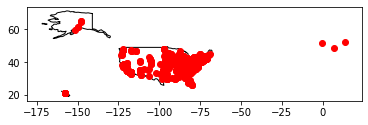

In [53]:
# create a mapspace for the geodataframe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

usa = world.query('name == "United States of America"')

ax = usa.plot(
    color='white', edgecolor='black'
)

mappable_gdf.plot(ax=ax, color='red')

plt.show()

There's still appear to be 3 very far to the east of North America... I can identify thes points by sorting the Longitude in descending order:

In [55]:
# fix a datatype problem for sorting... 
mappable_gdf = mappable_gdf.astype({'Longitude':'float64','Latitude':'float64'})

# find the farthest east... 
mappable_gdf.sort_values(by=['Longitude'],ascending=False).head(5)

,AppNumber,Institution,InstCity,InstState,InstPostalCode,InstCountry,CongressionalDistrict,Latitude,Longitude,YearAwarded,...,Division,AwardOutright,AwardMatching,ProjectDesc,ToSupport,Participants,Disciplines,geoquery,coordinates,geometry
341,FT-10462-68,University of Southern Florida,Orlando,DE,32816,USA,7,52.524225,13.409345,1967,...,Research Programs,1500.0,0.0,No description,No to support statement,Richard Lukas [Project Director],"History, General",Orlando DE,"[13.4093448, 52.5242253]",POINT (13.40934 52.52423)
597,FA-10060-67,Unaffiliated Independent Scholar,Belmont,MA,02178-0000,USA,0,48.408657,7.238676,1967,...,Research Programs,13270.0,0.0,No description,No to support statement,Einar Haugen [Project Director],"Literature, Other",Belmont MA,"[7.2386756, 48.4086571]",POINT (7.23868 48.40866)
483,RO-10335-69,None,Dennis,MA,None,USA,0,51.519807,-0.137680,1968,...,Research Programs,4800.0,0.0,No description,No to support statement,NaN,Art History and Criticism,Dennis MA,"[-0.13767995578500702, 51.519807150000005]",POINT (-0.13768 51.51981)
645,FB-10135-67,University of Maine System,Orono,ME,04473-1513,USA,2,44.887320,-68.680500,1967,...,Research Programs,8140.0,0.0,No description,No to support statement,Jerome Nadelhaft [Project Director],U.S. History,Orono ME,"[-68.6805, 44.88732]",POINT (-68.68050 44.88732)
182,FB-10085-67,Colby College,Waterville,ME,04901-8840,USA,1,44.541900,-69.639730,1967,...,Research Programs,8140.0,0.0,No description,No to support statement,Dorothy Koonce [Project Director],Classics,Waterville ME,"[-69.63973, 44.5419]",POINT (-69.63973 44.54190)


These were geocoded in Europe. 

In [56]:
#row 341
geocode('Orlando DE')

Location(Orlando, 2, Münzstraße, Scheunenviertel, Mitte, Berlin, 10178, Deutschland, (52.5242253, 13.4093448, 0.0))

In [57]:
# this one appears to be a mistake in the data: Florida, not Delaware
mappable_gdf.loc[341]

AppNumber                                     FT-10462-68
Institution                University of Southern Florida
InstCity                                          Orlando
InstState                                              DE
InstPostalCode                                      32816
InstCountry                                           USA
CongressionalDistrict                                   7
Latitude                                          52.5242
Longitude                                         13.4093
YearAwarded                                          1967
ProjectTitle                          Title not available
Program                                   Summer Stipends
Division                                Research Programs
AwardOutright                                        1500
AwardMatching                                           0
ProjectDesc                                No description
ToSupport                         No to support statement
Participants  

In [58]:
#row 597
geocode('Belmont MA')

Location(Belmont, Molsheim, Bas-Rhin, Grand Est, France métropolitaine, 67130, France, (48.4086571, 7.2386756, 0.0))

In [59]:
#row 483
geocode('Dennis MA')

Location(Dennis, 30, Cleveland Street, Cavendish Square & Oxford Market (South), Fitzrovia, City of Westminster, London, Greater London, England, W1T 4NG, United Kingdom, (51.519807150000005, -0.13767995578500702, 0.0))

I could've avoided this by telling the geocoder to prefer locations in North America. Nominatim, for example, provides options for `bounded` or `country_codes` to limit results. If I am geocoding a longer listin future, I would consider this as an option. For now, these can be corrected by providing a more specific country string with the request:

In [60]:
#this is better... 
geocode('Dennis MA USA')

Location(Dennis, Barnstable County, Massachusetts, United States, (41.7353872, -70.1939087, 0.0))

Following @cduvallet's example, I'm creating a function to update location records. The function takes a specified dataframe, row index, and Location() information.

In [61]:
def update_location(gdf, rowIndex, location):
    '''
    The function updates a record's latitude, longitude, and adds a geo Point entry
    The To specify the changes: 
        gdf is a specific dataframe
        rowIndex is the numerical index or Name of the row to update
        location is a new geoquery string to call for a Lcoation() object from the (Nominatim) geocoder
    The function requires the geocoder to be already implemented as geocode() and for Point to be imported from shapely. 
    '''
    newloc = geocode(location)
    gdf.at[rowIndex, 'Latitude'] = newloc.latitude
    gdf.at[rowIndex, 'Longitude'] = newloc.longitude
    # create a Point
    gdf.at[rowIndex, 'geometry'] = Point(newloc.longitude,newloc.latitude)

I'll test this on item 341. This one had a typo: the state was listed as Delaware, not Florida, so I'll provide the correct geoquery to the function, which will query Nominatim and update the data.

In [62]:
# test the function ... 
#row 341
#geocode('Orlando FL')
update_location(mappable_gdf, 341, 'Orlando FL')

#while we're at it, fix the data typo in the InstState field, also in the previous dataframes
mappable_gdf.at[341,'InstState'] = 'FL'
mappable_grant_info.at[341,'InstState'] = 'FL'
cleaned_grants_for_mappable.at[341,'InstState'] = 'FL'

mappable_gdf.loc[341]

AppNumber                                          FT-10462-68
Institution                     University of Southern Florida
InstCity                                               Orlando
InstState                                                   FL
InstPostalCode                                           32816
InstCountry                                                USA
CongressionalDistrict                                        7
Latitude                                                28.548
Longitude                                             -81.4128
YearAwarded                                               1967
ProjectTitle                               Title not available
Program                                        Summer Stipends
Division                                     Research Programs
AwardOutright                                             1500
AwardMatching                                                0
ProjectDesc                                     No desc

That looks good, so now I will fix the remaining two.

In [63]:
# update the other two points
update_location(mappable_gdf, 483, 'Dennis MA USA')
update_location(mappable_gdf, 597, 'Belmont MA USA')

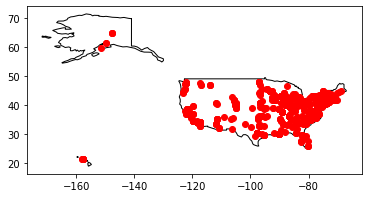

In [64]:
# remap... 
ax = usa.plot(
    color='white', edgecolor='black'
)
mappable_gdf.plot(ax=ax, color='red')

plt.show()

At least all of the points appear to be in logical places now, even if there may be some underlying noise. This brings the data to a point that is clean enough to map! 
But first, what other cool things can we do with the data using gepandas?

### Geopandas supports various data filtering

Now that the data is more or less in a shape that I want, it is ready for more analysis and visualization. We can count the number of awards by state, see all of the awards in a given state, or tally the amount of money awarded to a particular geographic area. And of course, we can make some more detailed maps! First, try some of the filtering and analyzing of the data that pandas supports. 

For example, how may grants were made to each state? 

In [65]:
# use groupby to count by state
mappable_gdf.groupby('InstState').InstState.count()

InstState
AK      6
AL      5
AR      1
AZ     13
CA    111
CO     10
CT     28
DC     44
DE     12
FL     18
GA     11
HI      8
IA     12
ID      1
IL     36
IN     23
KS      7
KY      7
LA      8
MA     76
MD     29
ME      3
MI     31
MN     14
MO      9
MS      7
MT      3
NC     33
ND      6
NE      7
NH      1
NJ     36
NM      2
NV      2
NY    146
OH     32
OK     10
OR      6
PA     53
RI      7
SC      9
SD      4
TN     20
TX     26
UT      3
VA     22
VT      3
WA     11
WI     16
WV      3
WY      6
Name: InstState, dtype: int64

Or I can ask how what grants were made to a specific state:

In [67]:
# show grants from Montana
mappable_gdf[mappable_gdf['InstState']=='MT']

,AppNumber,Institution,InstCity,InstState,InstPostalCode,InstCountry,CongressionalDistrict,Latitude,Longitude,YearAwarded,...,Division,AwardOutright,AwardMatching,ProjectDesc,ToSupport,Participants,Disciplines,geoquery,coordinates,geometry
326,FT-10374-68,University of Montana,Missoula,MT,59801-4494,USA,1,46.86494,-113.98401,1967,...,Research Programs,1500.0,0.0,No description,No to support statement,Duane Hampton [Project Director],U.S. History,Missoula MT,"[-113.98401, 46.86494]",POINT (-113.98401 46.86494)
348,FT-10738-69,University of Montana,Missoula,MT,59801-4494,USA,1,46.86494,-113.98401,1969,...,Research Programs,1500.0,0.0,Study of the concept of family in the politica...,No to support statement,Richard Chapman [Project Director],"Political Science, General",Missoula MT,"[-113.98401, 46.86494]",POINT (-113.98401 46.86494)
921,RO-10179-67,University of Montana,Missoula,MT,59801-4494,USA,1,46.86494,-113.98401,1967,...,Research Programs,1370.0,0.0,No description,No to support statement,Joseph Mussulman [Project Director],"History, General",Missoula MT,"[-113.98401, 46.86494]",POINT (-113.98401 46.86494)


In [68]:
Minnesota_1960s_grants = mappable_gdf[mappable_gdf['InstState'] == 'MN']

In [69]:
Minnesota_1960s_grants.head()

,AppNumber,Institution,InstCity,InstState,InstPostalCode,InstCountry,CongressionalDistrict,Latitude,Longitude,YearAwarded,...,Division,AwardOutright,AwardMatching,ProjectDesc,ToSupport,Participants,Disciplines,geoquery,coordinates,geometry
174,FA-10546-68,None,Minneapolis,MN,None,USA,0,44.97730,-93.265469,1967,...,Research Programs,15520.0,0.0,No description,No to support statement,NaN,American Literature,Minneapolis MN,"[-93.2654692, 44.9772995]",POINT (-93.26547 44.97730)
188,FB-10105-67,None,Minneapolis,MN,None,None,0,44.97730,-93.265469,1967,...,Research Programs,8140.0,0.0,No description,No to support statement,NaN,U.S. History,Minneapolis MN,"[-93.2654692, 44.9772995]",POINT (-93.26547 44.97730)
426,RO-10036-67,"University of Minnesota, Twin Cities",Minneapolis,MN,55455-0433,USA,5,44.97779,-93.236240,1967,...,Research Programs,18728.0,0.0,No description,No to support statement,Harrold Alllen [Project Director],Linguistics,Minneapolis MN,"[-93.23624, 44.97779]",POINT (-93.23624 44.97779)
477,RO-10293-68,None,Minneapolis,MN,None,None,0,44.97730,-93.265469,1968,...,Research Programs,18730.0,0.0,No description,No to support statement,NaN,Linguistics,Minneapolis MN,"[-93.2654692, 44.9772995]",POINT (-93.26547 44.97730)
650,FB-10159-67,"University of Minnesota, Twin Cities",Minneapolis,MN,55455-0433,USA,5,44.97779,-93.236240,1967,...,Research Programs,8140.0,0.0,No description,No to support statement,Jasper Hopkins [Project Director],"Philosophy, General",Minneapolis MN,"[-93.23624, 44.97779]",POINT (-93.23624 44.97779)


And I can map grants in a particular state:

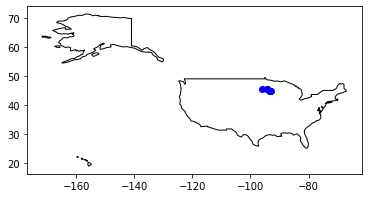

In [70]:
# re map... 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

usa = world.query('name == "United States of America"')

ax = usa.plot(
    color='white', edgecolor='black'
)
Minnesota_1960s_grants.plot(ax=ax, color='blue')

plt.show()

# 02c. Exporting

## Output the data as geojson

Before moving on, I want to conclude this section by creating outputting the data as geojson. This allows us to reuse or share the cleaned data with others, or port it into future visualization tools. For example, the data file can be ported into tools that have increased dynamic mapping capabilities, such as [leaflet.js](https://leafletjs.com/examples/geojson/) or [geojson.io](https://geojson.io/).

Geopandas uses the `fiona` library for this functions, so you may need to install and import it.

In [ ]:
#!pip install fiona
#import fiona

In [71]:
# get rid of those useless coordinate & geoquery fields
mappable_gdf = mappable_gdf.drop(['coordinates'], axis=1)
mappable_gdf = mappable_gdf.drop(['geoquery'], axis=1)
mappable_gdf = mappable_gdf.drop(['AwardMatching'], axis=1)

In [72]:
# output cleaned data to geojson

mappable_gdf.to_file('neh_1960s_grants.geojson', driver='GeoJSON')

This notebook used many of the analysis and transformation features in python to analyze, clean, and transform the source dataset of NEH's grants from the 1960s. Now I have a dataset, which I will reuse in the next steps as a basic data for mapping. Stay tuned for the next notebooks to follow this process. 

### Reference list

Credit to the examples in these tutorials (as of January 2021), which were highly informative to the exploratory work outlined above:

* Duong Vu, "[Introduction to Geospatial Data in Python](http://datacamp.com/community/tutorials/geospatial-data-python)" at _Datacamp_, published 24 October 2018.
* "[Using GeoJson with Leaflet](https://leafletjs.com/examples/geojson/)" at _leaflet.js_
* Lesley Cordero, "[Getting Started on Geospatial Analysis with Python, GeoJSON and GeoPandas](https://www.twilio.com/blog/2017/08/geospatial-analysis-python-geojson-geopandas.html)" at Twilio, published 14 August 2017.
* Claire Duvallet, "[Mapping my cross-country road trip with Python](https://cduvallet.github.io/posts/2020/02/road-trip-map)", published 9 February 2020.
* Dani Arribas-Bel, "[Mapping in Python with geopandas](http://darribas.org/gds15/content/labs/lab_03.html)", from Geographic Data Science '15. Provides a lot of useful information about creating more complex plots.
* @carsonfarmer offers a great overview of using python for geospatial data wrangling, including an overview of pandas for data analysis, geopandas, and many other geospatial tools available in the python and Jupyter environment; see https://github.com/carsonfarmer/python_geospatial/tree/master/notebooks 

See these sites for US state shapefile information: 

* Eric Celeste http://eric.clst.org/tech/usgeojson
* US Census provides various geographic files for US states and other entities: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html